# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_32', 'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_20', 'ORACLE.run1_44', 'ORACLE.run1_8', 'ORACLE.run1_14', 'ORACLE.run1_26'}


{'ORACLE.run2_44', 'ORACLE.run2_50', 'ORACLE.run2_8', 'ORACLE.run2_26', 'ORACLE.run2_20', 'ORACLE.run2_32', 'ORACLE.run2_14', 'ORACLE.run2_38'}


tensor([[[ 1.3646,  0.2454,  1.0112,  ..., -0.3043, -0.9228, -0.2945],
         [ 0.3142,  0.4614, -0.0393,  ...,  1.2566,  0.2552, -1.2762]],

        [[ 0.6683,  1.0614, -1.4840,  ..., -1.8182, -0.5602,  1.0319],
         [ 0.5995,  0.5504, -0.1671,  ..., -1.1990, -0.4226, -0.2260]],

        [[-0.8064, -0.1854,  0.7508,  ...,  0.1761, -0.2781, -0.1946],
         [ 0.5098,  0.6488,  0.8527,  ..., -0.2410,  0.8620, -1.2513]],

        ...,

        [[ 0.5589, -0.2290, -1.0078,  ..., -0.1191, -0.7604, -1.4933],
         [ 0.0550,  0.1741,  0.8795,  ...,  0.8429, -0.1283,  1.2826]],

        [[ 0.3345,  0.6504, -0.6875,  ...,  2.0905,  1.3101,  0.4460],
         [ 0.7433,  0.2137, -0.3066,  ...,  1.0313,  0.4738,  0.6132]],

        [[ 0.2057, -0.5544, -1.2518,  ..., -0.3577,  0.7153,  1.0730],
         [ 0.4381, -0.7600, -1.4396,  ...,  0.3666, -0.7690,  1.5826]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 9.7975, train_label_loss: 2.7620, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3230.4944, train_label_loss: 2.0773, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3205.1267, train_label_loss: 0.8615, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3219.7394, train_label_loss: 0.7159, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3205.8116, train_label_loss: 1.2658, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3223.5730, train_label_loss: 0.8710, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3223.0761, train_label_loss: 0.6102, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3213.0965, train_label_loss: 0.5395, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3217.7417, train_label_loss: 0.5945, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3215.5386, train_label_loss: 1.3445, 


epoch: 1, source_val_acc_label: 0.6353, target_val_acc_label: 0.6199, source_val_label_loss: 1.0052, target_val_label_loss: 1.0421, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9602, train_label_loss: 0.7960, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3231.4264, train_label_loss: 0.5356, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3234.3229, train_label_loss: 1.2724, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3240.6567, train_label_loss: 0.5480, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3234.2856, train_label_loss: 0.4301, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3245.9577, train_label_loss: 0.6925, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3244.8238, train_label_loss: 1.2004, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3236.5450, train_label_loss: 1.0665, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3245.2705, train_label_loss: 1.0791, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3253.3922, train_label_loss: 1.0957, 


epoch: 2, source_val_acc_label: 0.6755, target_val_acc_label: 0.6558, source_val_label_loss: 0.8588, target_val_label_loss: 0.9211, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.9677, train_label_loss: 0.7773, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3225.4431, train_label_loss: 1.3019, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3238.6201, train_label_loss: 1.2199, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3241.0639, train_label_loss: 0.7981, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3235.2631, train_label_loss: 0.4444, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3242.2271, train_label_loss: 0.6930, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3239.6436, train_label_loss: 1.0781, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3232.5536, train_label_loss: 0.9022, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3240.1152, train_label_loss: 1.1395, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3242.9763, train_label_loss: 0.5793, 


epoch: 3, source_val_acc_label: 0.6973, target_val_acc_label: 0.6775, source_val_label_loss: 0.8172, target_val_label_loss: 0.8895, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.9661, train_label_loss: 0.3962, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3231.2267, train_label_loss: 0.5542, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3236.9037, train_label_loss: 0.9631, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3245.0619, train_label_loss: 0.9359, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3230.2149, train_label_loss: 0.6050, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3242.1749, train_label_loss: 1.3224, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3246.5256, train_label_loss: 1.2423, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3231.4646, train_label_loss: 0.3641, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3236.9778, train_label_loss: 0.5549, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3248.9699, train_label_loss: 0.6672, 


epoch: 4, source_val_acc_label: 0.7111, target_val_acc_label: 0.6920, source_val_label_loss: 0.7847, target_val_label_loss: 0.8619, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.9621, train_label_loss: 0.4763, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3228.1868, train_label_loss: 0.8657, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3232.3002, train_label_loss: 0.6746, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3230.3999, train_label_loss: 0.4558, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3224.4521, train_label_loss: 0.6649, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3239.2027, train_label_loss: 0.8599, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3249.3804, train_label_loss: 0.6313, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3234.7009, train_label_loss: 0.3442, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3239.7961, train_label_loss: 0.8348, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3244.5869, train_label_loss: 0.6137, 


epoch: 5, source_val_acc_label: 0.7175, target_val_acc_label: 0.6990, source_val_label_loss: 0.7775, target_val_label_loss: 0.8592, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9650, train_label_loss: 0.4723, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3233.0479, train_label_loss: 0.5720, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3235.9369, train_label_loss: 0.7730, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3240.5211, train_label_loss: 1.0976, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3237.5318, train_label_loss: 0.5222, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3247.7293, train_label_loss: 0.6334, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3250.6643, train_label_loss: 0.6157, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3234.6839, train_label_loss: 0.4490, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3246.5770, train_label_loss: 0.5956, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3251.2668, train_label_loss: 0.6600, 


epoch: 6, source_val_acc_label: 0.7210, target_val_acc_label: 0.7065, source_val_label_loss: 0.7791, target_val_label_loss: 0.8611, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9648, train_label_loss: 0.9613, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3224.4768, train_label_loss: 0.4684, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3237.1998, train_label_loss: 0.3652, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3246.0133, train_label_loss: 0.3693, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3233.5318, train_label_loss: 0.2545, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3244.6630, train_label_loss: 0.6506, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3239.9344, train_label_loss: 0.5347, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3235.4549, train_label_loss: 0.3636, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3235.5009, train_label_loss: 0.3488, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3251.1654, train_label_loss: 0.6117, 


epoch: 7, source_val_acc_label: 0.7196, target_val_acc_label: 0.7035, source_val_label_loss: 0.7693, target_val_label_loss: 0.8488, 


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.9688, train_label_loss: 0.1925, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3216.3122, train_label_loss: 0.4045, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3231.5194, train_label_loss: 0.3880, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3229.9176, train_label_loss: 0.7921, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3223.3625, train_label_loss: 0.6445, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3240.8112, train_label_loss: 0.4957, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3248.2778, train_label_loss: 0.6790, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3244.7548, train_label_loss: 0.4508, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3237.5014, train_label_loss: 0.5525, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3245.5639, train_label_loss: 0.3386, 


epoch: 8, source_val_acc_label: 0.7260, target_val_acc_label: 0.7093, source_val_label_loss: 0.7750, target_val_label_loss: 0.8555, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.9659, train_label_loss: 0.3358, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3236.0729, train_label_loss: 0.2518, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3235.4876, train_label_loss: 0.2231, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3245.0046, train_label_loss: 0.7401, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3230.0131, train_label_loss: 0.4376, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3250.1262, train_label_loss: 0.2928, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3248.0880, train_label_loss: 0.3550, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3242.5818, train_label_loss: 0.6466, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3239.2419, train_label_loss: 0.5618, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3246.6720, train_label_loss: 0.4788, 


epoch: 9, source_val_acc_label: 0.7233, target_val_acc_label: 0.7059, source_val_label_loss: 0.7851, target_val_label_loss: 0.8653, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.9635, train_label_loss: 0.5357, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3226.6705, train_label_loss: 0.3337, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3245.8756, train_label_loss: 0.2690, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3227.0736, train_label_loss: 0.6892, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3230.4011, train_label_loss: 0.3808, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3242.5080, train_label_loss: 0.4539, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3247.3259, train_label_loss: 0.3609, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3236.3297, train_label_loss: 0.1484, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3231.6843, train_label_loss: 0.2253, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3245.1282, train_label_loss: 0.3016, 


epoch: 10, source_val_acc_label: 0.7277, target_val_acc_label: 0.7139, source_val_label_loss: 0.7922, target_val_label_loss: 0.8676, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9621, train_label_loss: 0.2424, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3228.0242, train_label_loss: 0.2247, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3225.6133, train_label_loss: 0.2399, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3231.7902, train_label_loss: 0.2820, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3225.6408, train_label_loss: 0.1129, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3246.9825, train_label_loss: 0.5094, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3243.8713, train_label_loss: 0.2151, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3231.6921, train_label_loss: 0.2461, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3239.3196, train_label_loss: 0.2411, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3247.7766, train_label_loss: 0.5646, 


epoch: 11, source_val_acc_label: 0.7205, target_val_acc_label: 0.7063, source_val_label_loss: 0.8157, target_val_label_loss: 0.8943, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.9600, train_label_loss: 0.4407, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3231.8280, train_label_loss: 0.2319, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3236.1465, train_label_loss: 0.4417, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3237.7783, train_label_loss: 0.2541, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3234.6950, train_label_loss: 0.2189, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3247.2904, train_label_loss: 0.5480, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3245.4005, train_label_loss: 0.3384, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3238.5766, train_label_loss: 0.1204, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3229.8236, train_label_loss: 0.3512, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3241.9368, train_label_loss: 0.3092, 


epoch: 12, source_val_acc_label: 0.7265, target_val_acc_label: 0.7107, source_val_label_loss: 0.8291, target_val_label_loss: 0.9108, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.9648, train_label_loss: 0.2822, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3237.6987, train_label_loss: 0.4483, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3237.0223, train_label_loss: 0.4294, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3228.3711, train_label_loss: 0.7635, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3232.9900, train_label_loss: 0.4323, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3243.8833, train_label_loss: 0.2931, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3247.9825, train_label_loss: 0.3112, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 3231.2625, train_label_loss: 0.3375, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3245.4351, train_label_loss: 0.5795, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3247.0199, train_label_loss: 0.3508, 


epoch: 13, source_val_acc_label: 0.7246, target_val_acc_label: 0.7084, source_val_label_loss: 0.8449, target_val_label_loss: 0.9295, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.9646, train_label_loss: 0.2943, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3225.9264, train_label_loss: 0.1141, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 3222.7893, train_label_loss: 0.2128, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 3243.7938, train_label_loss: 0.7957, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 3232.0528, train_label_loss: 0.2589, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 3240.5384, train_label_loss: 0.0304, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 3239.5800, train_label_loss: 0.3890, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 3233.2385, train_label_loss: 0.2967, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 3251.2119, train_label_loss: 0.1056, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 3244.5130, train_label_loss: 0.6095, 


epoch: 14, source_val_acc_label: 0.7222, target_val_acc_label: 0.7068, source_val_label_loss: 0.8716, target_val_label_loss: 0.9576, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

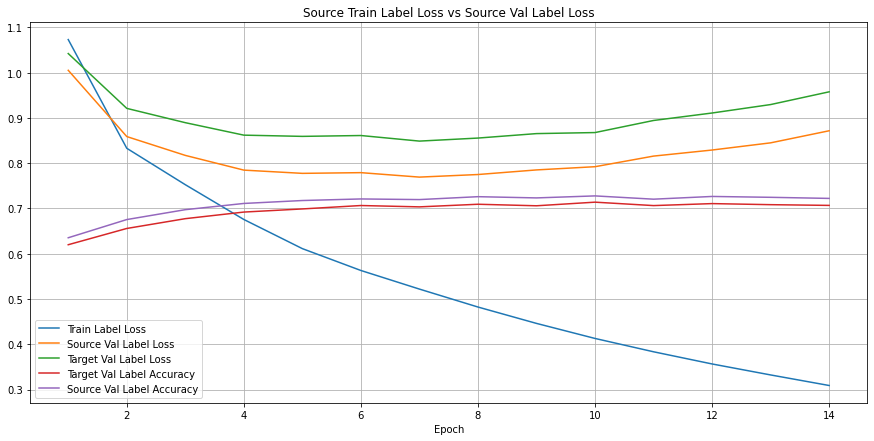

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

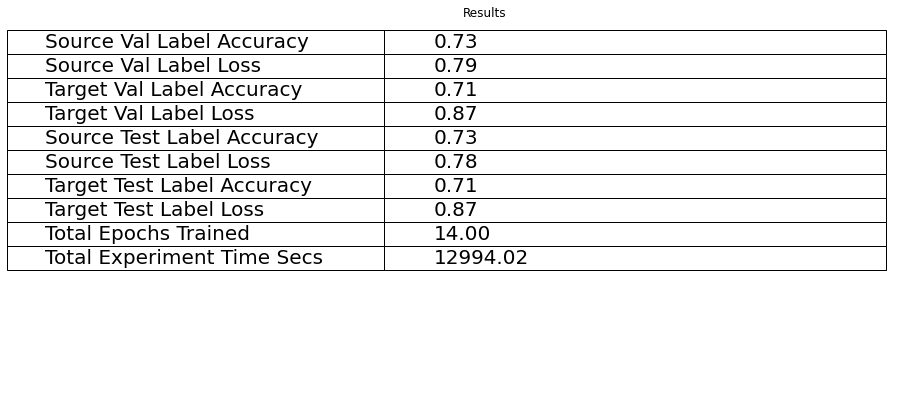

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

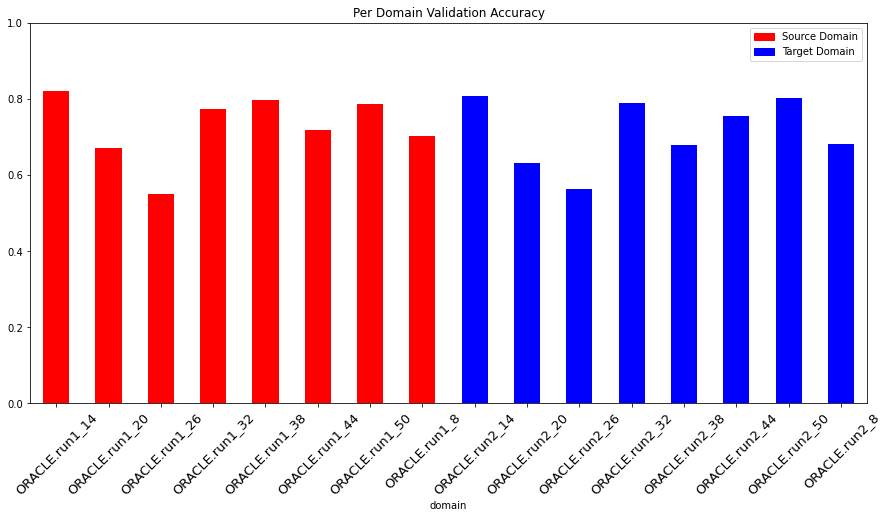

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7298111979166667 Target Test Label Accuracy: 0.7121354166666667
Source Val Label Accuracy: 0.7277408854166667 Target Val Label Accuracy: 0.7139127604166666


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"